<a href="https://colab.research.google.com/github/Pragu3704/promoter_or_not/blob/main/promoter_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading and unzipping dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q kagglehub
import kagglehub

In [ ]:
path = kagglehub.dataset_download("samira1992/promoter-or-not-bioinformatics-dataset")
print("Path to dataset files:", path)

100%|██████████| 4.76M/4.76M [00:00<00:00, 5.11MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samira1992/promoter-or-not-bioinformatics-dataset/versions/3


In [ ]:
target_dir = '/content/drive/MyDrive/Kaggle/promoter_or_not'
!cp -r "$path/"* "$target_dir"

In [ ]:
!ls "$target_dir"

bendability.tsv  non_promoter.csv  promoter.csv  promoter_or_not.ipynb


In [ ]:
!rm -r /root/.cache/kagglehub/datasets/samira1992/promoter-or-not-bioinformatics-dataset/versions/3

#Viewing data

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Kaggle/promoter_or_not/promoter.csv')
df.head()

,Promoter sequences
0,CTGTCCAATCATAAGCCTCACGTGACCTGCCGCGTAGGGAGGGCAC...
1,CCTTATTATACCTGTAAACTATTCTCTTCCTTTGTTACTTGCTTTT...
2,TTTGCCACACTGCAGCATTAGGATGGGACTTCTCTTCCTGTTCCTG...
3,ACAAATAACAAAGATAGTTTTAGTAGATTATATCTGGGCTGTAGTG...
4,GAGGAGAAATTGGAGACAACCTCCTCCCACAATCCTCCGCGGCTCA...


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Kaggle/promoter_or_not/non_promoter.csv')
df1.head()

,non Promoter sequences
0,ATCTCTAGCTCCTATACCACCACCACCACCATTACAGCGCCTCCCT...
1,ACTTTTTTCATGTTCTCCTTGAGTGAAGGATGAGGAAATTGAAAGC...
2,ATCTCCAGAGGGAGTCCAATCCCTGTCCTGTAATAACTGTAGAGCA...
3,CCTGGTGACCAAGGTGGTGGCGGTGGACGCAGACTCGGGATACAAC...
4,AGATCAGCAAGGACAACTCCTGCAAAGAAAACTGTACTTGTTCCTC...


In [ ]:
import pandas as pd

# read TSV with explicit column names
df2 = pd.read_csv(
    '/content/drive/MyDrive/Kaggle/promoter_or_not/bendability.tsv',
    sep='\t',
    header=None,
    names=['triplet', 'score']
)

# new row
new_row = pd.DataFrame([['aaa', -0.274]], columns=['triplet', 'score'])

# add to top
df2 = pd.concat([new_row, df2], ignore_index=True)

df2.head()

,triplet,score
0,aaa,-0.274
1,aaa,-0.274
2,aac,-0.205
3,aag,-0.081
4,aat,-0.280


In [ ]:
print(f"Non-promoter sequences: {len(df)}")
print(f"Promoter sequences: {len(df1)}")
print(f"Bendability triplets: {len(df2)}")

Non-promoter sequences: 30000
Promoter sequences: 30000
Bendability triplets: 65


#Importing all important libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.base import BaseEstimator
from xgboost import XGBClassifier

#Binary encoding promoter and non promoter

In [ ]:
df = df.rename(columns={df.columns[0]: "sequence"})
df1 = df1.rename(columns={df1.columns[0]: "sequence"})
df["label"] = 1      # promoter
df1["label"] = 0     # non-promoter
bend_dict = {
    k.upper(): v
    for k, v in zip(df2["triplet"], df2["score"])
}
df3 = pd.concat([df, df1], ignore_index=True)
print("Data prepared:")
print(f"Total sequences: {len(df3)}")
print(f"Bendability dictionary size: {len(bend_dict)}")

print("=" * 80)
print("Dataset Info:")
print(df3.info())

print("=" * 80)
print("Label distribution:")
print(df3["label"].value_counts())

display(df3)

Data prepared:
Total sequences: 60000
Bendability dictionary size: 64
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  60000 non-null  object
 1   label     60000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.6+ KB
None
Label distribution:
label
1    30000
0    30000
Name: count, dtype: int64


,sequence,label
0,CTGTCCAATCATAAGCCTCACGTGACCTGCCGCGTAGGGAGGGCAC...,1
1,CCTTATTATACCTGTAAACTATTCTCTTCCTTTGTTACTTGCTTTT...,1
2,TTTGCCACACTGCAGCATTAGGATGGGACTTCTCTTCCTGTTCCTG...,1
3,ACAAATAACAAAGATAGTTTTAGTAGATTATATCTGGGCTGTAGTG...,1
4,GAGGAGAAATTGGAGACAACCTCCTCCCACAATCCTCCGCGGCTCA...,1
...,...,...
59995,GCCAGGCAGCTTTTCGGCATGCTTGGTCGCAGCAAGGGATCACACT...,0
59996,CTGCCCCTTTGTCTGTATCAATAGTGGTTTTAAACAAAATTTATTT...,0
59997,GCATCATTTTATTTCATCTGTAAACCTTTTGGCATGAACATTTCTT...,0
59998,AATAAGATTGTAACTTTCAGATAAGTTAAAGCCAGGAAAAACAAGA...,0


#Extracting features and summarising findings:
*   TATA Box presence
*   TTGCA sequence presence
*   CpG islands ratio
*   Purine:pyrimidine ratio
*   Avg bendeability



In [ ]:
#CpG islands ratio
def cpg_ratio(seq):
    seq = seq.upper()
    g_count = seq.count('G')
    c_count = seq.count('C')
    cg_count = seq.count('CG')

    if len(seq) == 0:
        return 0

    expected = (g_count * c_count) / len(seq)
    return cg_count / expected if expected > 0 else 0

In [ ]:
#TATA box presnece
def tata_box_presence(seq):
    return 1 if "TATA" in seq.upper() else 0

In [ ]:
#TTGCA sequence presence
def ttgca_presence(seq):
    return 1 if "TTGCA" in seq.upper() else 0

In [ ]:
#Purine:pyramidine ratio
def purine_pyrimidine_ratio(seq):
    seq = seq.upper()
    purines = seq.count('A') + seq.count('G')      # Purines
    pyrimidines = seq.count('C') + seq.count('T')  # Pyrimidines
    return purines / pyrimidines if pyrimidines > 0 else 0

In [ ]:
#Avg bendeability
def avg_bendability(seq):
    seq = seq.upper()
    scores = []

    for i in range(len(seq) - 2):
        tri = seq[i:i+3]
        if tri in bend_dict:
            scores.append(bend_dict[tri])

    return np.mean(scores) if scores else 0

In [ ]:
#Feature creation
df3["sequence"] = df3["sequence"].astype(str)
df3["ttgca_presence"] = df3["sequence"].apply(ttgca_presence)
df3["purine_pyrimidine_ratio"] = df3["sequence"].apply(purine_pyrimidine_ratio)
df3["cpg_ratio"] = df3["sequence"].apply(cpg_ratio)
df3["tata_box_presence"] = df3["sequence"].apply(tata_box_presence)
df3["bendability"] = df3["sequence"].apply(avg_bendability)
print(f"Dataset shape: {df3.shape}")
print(f"Number of features: {df3.shape[1] - 2}")

Dataset shape: (60000, 7)
Number of features: 5


In [ ]:
#Summarisation of feature statistics
# Define feature columns
feature_cols = ['ttgca_presence', 'cpg_ratio', 'tata_box_presence',
                'bendability','purine_pyrimidine_ratio']

# Display feature statistics
print("Feature Statistics:")
display(df3[feature_cols + ['label']].describe())

Feature Statistics:


,ttgca_presence,cpg_ratio,tata_box_presence,bendability,purine_pyrimidine_ratio,label
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.225717,0.552379,0.353317,-0.022135,1.020724,0.500000
std,0.418057,0.397027,0.478004,0.015905,0.352126,0.500004
min,0.000000,0.000000,0.000000,-0.168526,0.171206,0.000000
25%,0.000000,0.211279,0.000000,-0.030543,0.832117,0.000000
50%,0.000000,0.476055,0.000000,-0.019611,0.980263,0.500000
75%,0.000000,0.870949,1.000000,-0.011706,1.165468,1.000000
max,1.000000,3.157343,1.000000,0.097960,49.200000,1.000000


#Plotting graphs to identify patterns of defined features in data

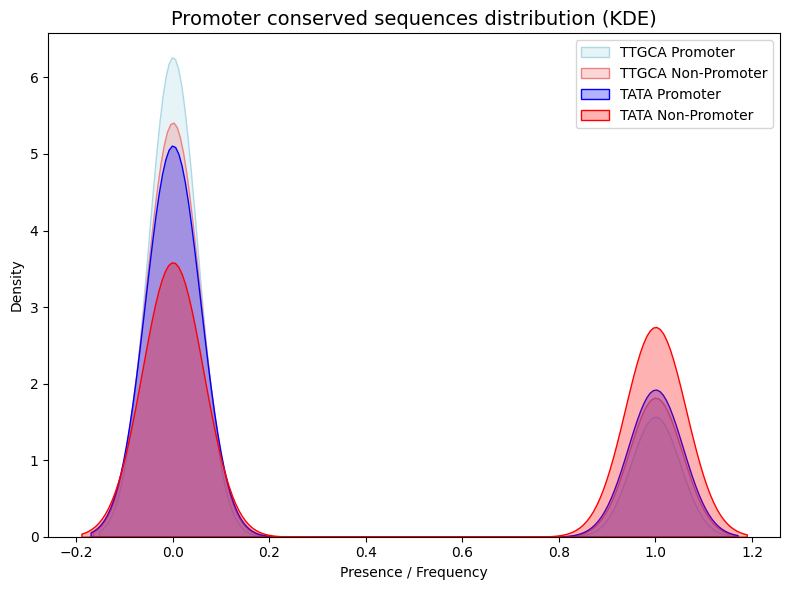

In [ ]:
#KDE curve plot to visualise presence of TATA box and TTGCA sequence in promoters and non-promoters

fig, ax = plt.subplots(figsize=(8, 6))

# TTGCA
sns.kdeplot(
    data=df3[df3['label'] == 1],
    x='ttgca_presence',
    fill=True,
    alpha=0.3,
    color='lightblue',
    label='TTGCA Promoter',
    ax=ax
)

sns.kdeplot(
    data=df3[df3['label'] == 0],
    x='ttgca_presence',
    fill=True,
    alpha=0.3,
    color='lightcoral',
    label='TTGCA Non-Promoter',
    ax=ax
)

# TATA box
sns.kdeplot(
    data=df3[df3['label'] == 1],
    x='tata_box_presence',
    fill=True,
    alpha=0.3,
    color='blue',
    label='TATA Promoter',
    ax=ax
)

sns.kdeplot(
    data=df3[df3['label'] == 0],
    x='tata_box_presence',
    fill=True,
    alpha=0.3,
    color='red',
    label='TATA Non-Promoter',
    ax=ax
)

ax.set_title('Promoter conserved sequences distribution (KDE)', fontsize=14)
ax.set_xlabel('Presence / Frequency')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

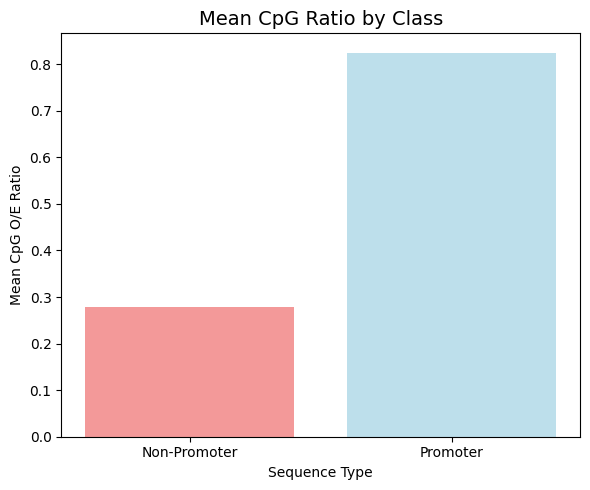

In [ ]:
#Mean CpG ratio by class

# compute means
cpg_means = (
    df3.groupby('label')['cpg_ratio']
       .mean()
       .reset_index()
)

# map labels to names
cpg_means['label_name'] = cpg_means['label'].map({
    0: 'Non-Promoter',
    1: 'Promoter'
})

plt.figure(figsize=(6, 5))

plt.bar(
    cpg_means['label_name'],
    cpg_means['cpg_ratio'],
    color=['lightcoral', 'lightblue'],
    alpha=0.8
)

plt.title('Mean CpG Ratio by Class', fontsize=14)
plt.xlabel('Sequence Type')
plt.ylabel('Mean CpG O/E Ratio')

plt.tight_layout()
plt.show()


/tmp/ipython-input-3025495351.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


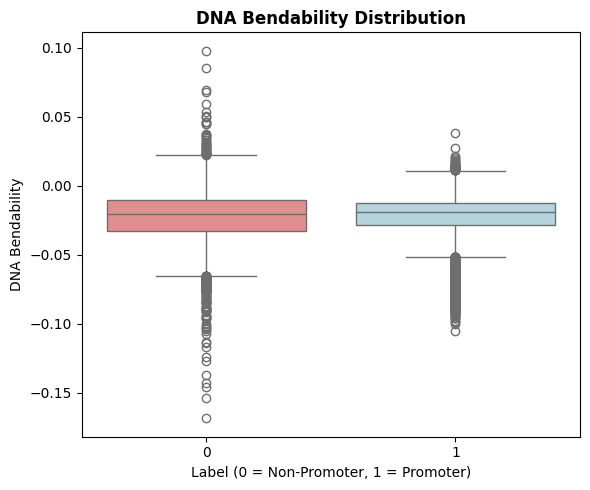

In [ ]:
#Box plot for DNA bendability distribution
plt.figure(figsize=(6, 5))

sns.boxplot(
    data=df3,
    x='label',
    y='bendability',
    palette=['lightcoral', 'lightblue']
)

plt.title('DNA Bendability Distribution', fontweight='bold')
plt.xlabel('Label (0 = Non-Promoter, 1 = Promoter)')
plt.ylabel('DNA Bendability')

plt.tight_layout()
plt.show()

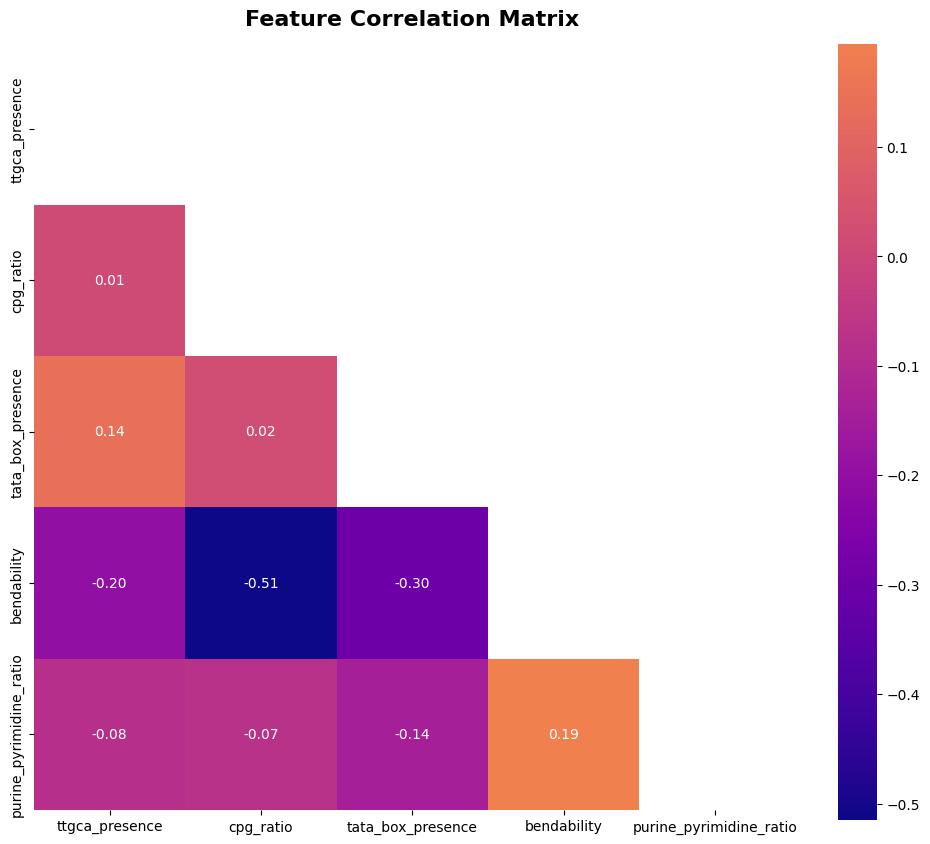

In [ ]:
#Feature correlation matrix
plt.figure(figsize=(10, 10))
corr_matrix = df[feature_cols].corr()
mask = np.triu(np.ones_like(corr_matrix))

sns.heatmap(corr_matrix, annot=True, cmap='plasma', center=0, fmt='.2f',
            square=True,mask=mask,cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#Model definition, training, testing and comparision

We train and compare the following classifiers:
*   Logistic regression
*   Random forest
*   Naive-Bayes





In [ ]:
#Preparing data
X = df3[feature_cols]
y = df3["label"]


print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Features shape: (60000, 5)
Target shape: (60000,)


In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split:")
print(f"Training: {X_train.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")

Data split:
Training: 48,000 samples
Test: 12,000 samples
Features: 5


In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(
        random_state=32,
        max_iter=1000
    ),

    "Naive Bayes": GaussianNB(),

    "Random Forest": RandomForestClassifier(
        random_state=32,
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    ),

    "XGBoost": XGBClassifier(
        random_state=32,
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.2
    )
}

In [ ]:
#Model training and evaluation
results = {}

for name, model in models.items():
    print(f"\n  {name}...")

    # Training
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Cross-validation for robust evaluation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}" if auc else "   AUC: N/A")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")

    # Store results
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "auc": auc,
        "cv_scores": cv_scores,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba
    }


  Logistic Regression...
Accuracy: 0.8498
AUC: 0.9048
CV Accuracy: 0.8508 (±0.0034)

  Naive Bayes...
Accuracy: 0.8442
AUC: 0.8931
CV Accuracy: 0.8456 (±0.0085)

  Random Forest...
Accuracy: 0.8594
AUC: 0.9310
CV Accuracy: 0.8596 (±0.0061)

  XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:15:14] WARNING: /w

Accuracy: 0.9811
AUC: 0.9971
CV Accuracy: 0.9772 (±0.0040)


In [ ]:
# Identify best model
best_model_name = max(results.keys(), key=lambda x: results[x]["accuracy"])
print(f"BEST MODEL: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")

BEST MODEL: XGBoost (Accuracy: 0.9811)


In [ ]:
# Detailed classification reports
for name in results.keys():
    print(f"Report - {name}")
    print("=" * 50)
    print(classification_report(y_test, results[name]['y_pred'],
                              target_names=['Non-Promoter', 'Promoter']))

Report - Logistic Regression
              precision    recall  f1-score   support

Non-Promoter       0.83      0.87      0.85      6000
    Promoter       0.87      0.83      0.85      6000

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000

Report - Naive Bayes
              precision    recall  f1-score   support

Non-Promoter       0.83      0.87      0.85      6000
    Promoter       0.87      0.81      0.84      6000

    accuracy                           0.84     12000
   macro avg       0.85      0.84      0.84     12000
weighted avg       0.85      0.84      0.84     12000

Report - Random Forest
              precision    recall  f1-score   support

Non-Promoter       0.82      0.92      0.87      6000
    Promoter       0.91      0.80      0.85      6000

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
w

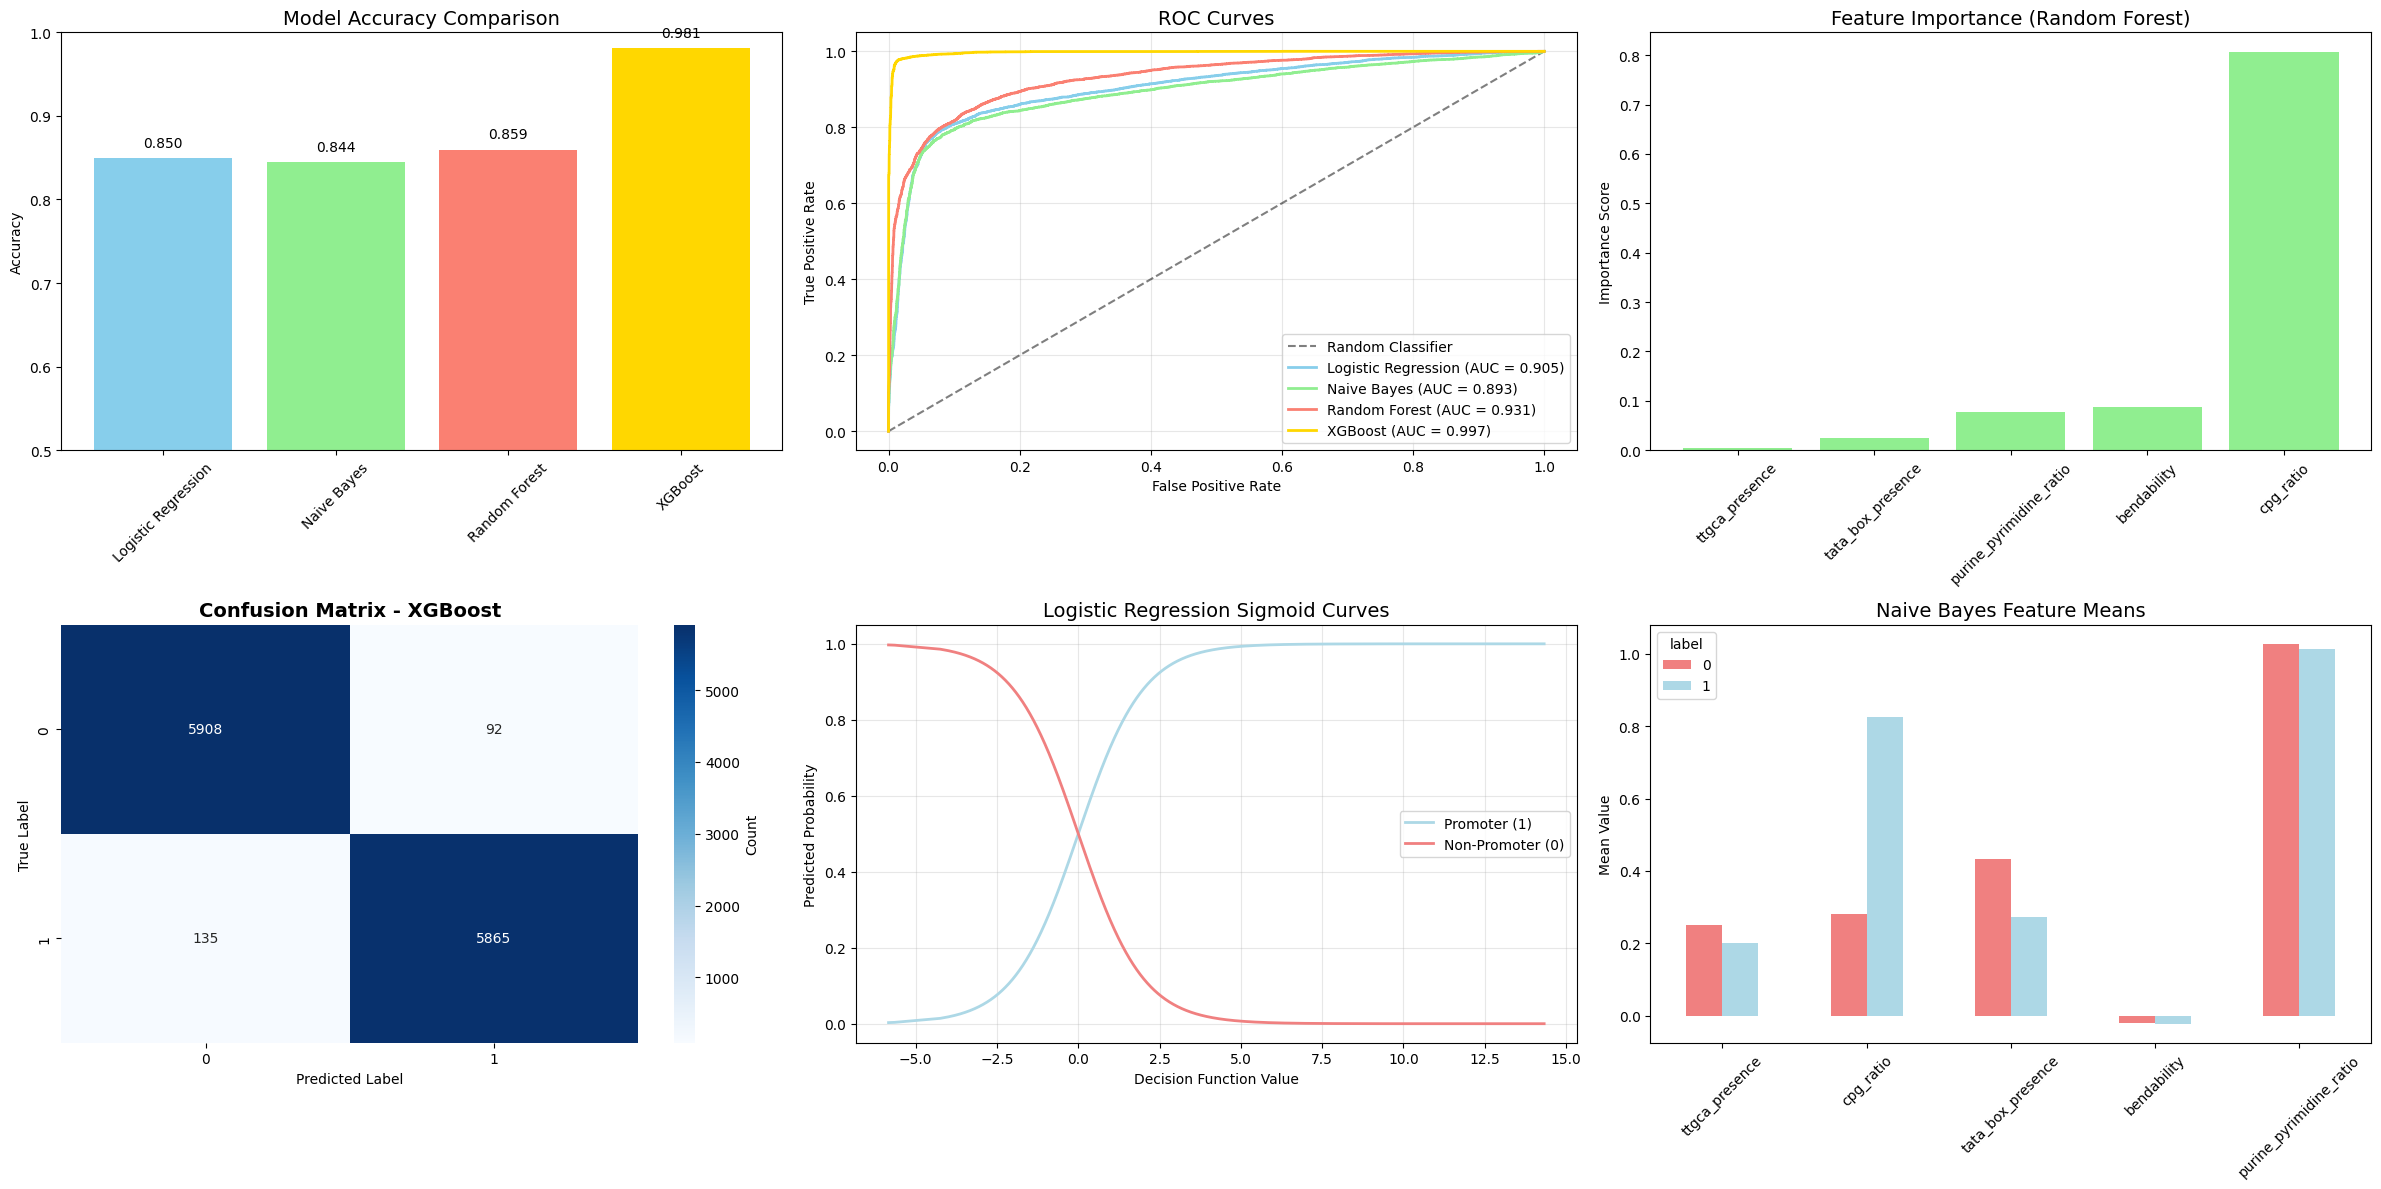

In [ ]:
# Detailed visualization of results

fig, axes = plt.subplots(2, 3, figsize=(24, 12))


# 1. Accuracy comparison

model_names = list(results.keys())
accuracies = [results[name]["accuracy"] for name in model_names]
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

bars = axes[0,0].bar(model_names, accuracies, color=colors)
axes[0,0].set_title('Model Accuracy Comparison', fontsize=14)
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0.5, 1.0)
axes[0,0].tick_params(axis='x', rotation=45)

for bar, acc in zip(bars, accuracies):
    axes[0,0].text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f'{acc:.3f}',
        ha='center',
        va='bottom'
    )


# 2. ROC curves

axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

for name, color in zip(model_names, colors):
    if results[name]["y_pred_proba"] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]["y_pred_proba"])
        auc_score = results[name]["auc"]
        axes[0,1].plot(
            fpr, tpr, color=color, linewidth=2,
            label=f'{name} (AUC = {auc_score:.3f})'
        )

axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves', fontsize=14)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)


# 3. Random Forest feature importance

rf_model = results["Random Forest"]["model"]

if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    importance_idx = np.argsort(importances)[-10:]
    feature_names = [feature_cols[i] for i in importance_idx]
    importance_vals = importances[importance_idx]

    axes[0,2].bar(feature_names, importance_vals, color='lightgreen')
    axes[0,2].set_title('Feature Importance (Random Forest)', fontsize=14)
    axes[0,2].set_ylabel('Importance Score')
    axes[0,2].tick_params(axis='x', rotation=45)


# 4. Confusion matrix (best model)

best_y_pred = results[best_model_name]["y_pred"]
cm = confusion_matrix(y_test, best_y_pred)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    ax=axes[1,0], cbar_kws={'label': 'Count'}
)

axes[1,0].set_title(
    f'Confusion Matrix - {best_model_name}',
    fontweight='bold', fontsize=14
)
axes[1,0].set_xlabel('Predicted Label')
axes[1,0].set_ylabel('True Label')


# 5. Logistic Regression coefficients

from scipy.special import expit  # sigmoid

# Logistic Regression sigmoid curves
lr_model = results["Logistic Regression"]["model"]

# decision scores on test set
z = lr_model.decision_function(X_test)

# sort for smooth curves
z_sorted = np.sort(z)

p1 = expit(z_sorted)        # P(y=1)
p0 = 1 - p1                 # P(y=0)

axes[1,1].plot(
    z_sorted, p1,
    color='lightblue',
    linewidth=2,
    label='Promoter (1)'
)

axes[1,1].plot(
    z_sorted, p0,
    color='lightcoral',
    linewidth=2,
    label='Non-Promoter (0)'
)

axes[1,1].set_title('Logistic Regression Sigmoid Curves', fontsize=14)
axes[1,1].set_xlabel('Decision Function Value')
axes[1,1].set_ylabel('Predicted Probability')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)



# 6. Naive Bayes feature means

nb_means = df3.groupby('label')[feature_cols].mean()

nb_means.T.plot(
    kind='bar',
    ax=axes[1,2],
    color=['lightcoral', 'lightblue']
)

axes[1,2].set_title('Naive Bayes Feature Means', fontsize=14)
axes[1,2].set_ylabel('Mean Value')
axes[1,2].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()
